## Introduction 
#### what is a neural network?
 A neural Network is a computational model inspired by the human brain. Each neuron recieves an activation signal from the preceeding layer and computes some value that is propoagated forward
 #### Key Concepts:
 - **Input Layer**: Receives the raw input data (e.g., pixel values from an image).
 - **Hidden Layers**: Perform computations to extract meaningful features.
 - **Output Layer**: Produces the final predictions (e.g., the digit class).

 #### Activation Functions:
 Activation functions (e.g., ReLU, sigmoid) introduce non-linearity into the model, enabling it to learn complex patterns.

 #### Loss Function:
 The loss function measures the error between the predicted outputs and the true labels. In this task, we'll use Cross Entropy Loss, which is commonly used for classification problems.

 #### Optimization:
 The optimizer (e.g., Stochastic Gradient Descent) updates the network's weights to minimize the loss function during training.

 #### Problem Statement:
 In this assignment, we will use the MNIST dataset to train a neural network to classify handwritten digits (0-9). We'll explore various hyperparameters, analyze their effects, and optionally use advanced techniques such as convolutional layers and dropout.

## 1 Data Processing
 before we attempt to train our model we must make sure that our data conforms with required criteria:
 - the samples are tensors
 - 60 % training , 20 % validation , 20 % test 
 - keep a "straigtified" manner to avoid data skewing

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Apply transformations (convert to tensor and normalize)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1] range
])

# Load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

# Split training dataset into train and validation sets
train_data, val_data = train_test_split(train_dataset, test_size=0.2, stratify=train_dataset.targets)

# Create DataLoader objects for efficient batching
batch_size = 15  # You can modify this in the analysis section
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Data preparation complete!")


Data preparation complete!


 now we build our neural network architecture. we will start with a basic model containing a single hidden layer.

In [10]:
# 2 create neural network structure
class Neural_Network_1_hidden_layer(nn.Module):
        def __init__(self, input_size=28*28, hidden_size=10, num_classes=10):
            super(Neural_Network_1_hidden_layer, self).__init__()
            self.fc1 = nn.Linear(input_size, hidden_size) 
            self.fc2 = nn.Linear(hidden_size, num_classes)

        def forward(self, x):
            x = x.view(-1, 28*28)  # Flatten the input
            x = torch.relu(self.fc1(x))  # Apply ReLU activation after first hidden layer
            x = self.fc2(x)  # Output layer
            return x

 before we start the training process we need to make sure that we are using GPU accelerated training 

In [11]:

# 3. Set device to GPU if available, else fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the model and move it to the selected device
model = Neural_Network_1_hidden_layer().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)


 we will now proceed to train our model for 10 epochs where each epoch consists of a training phase followed by a vildation phase.

In [12]:

# 4. Training Process
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0 # this is the cumulative loss during epoch
        correct_train = 0  
        total_train = 0
        
        # Train the model on the training set
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move to GPU
            
            optimizer.zero_grad()
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass (compute gradients)
            optimizer.step()  # Update weights

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)  # Get the predicted class
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train * 100
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)  # Move to GPU
                outputs = model(images)  # Forward pass
                loss = criterion(outputs, labels)

                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        avg_val_loss = running_loss / len(val_loader)
        val_accuracy = correct_val / total_val * 100
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    
    return train_losses, val_losses, train_accuracies, val_accuracies


In [13]:
# Train the model
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=10
)


Epoch [1/10], Train Loss: 0.5966, Train Accuracy: 82.25%, Validation Loss: 0.3849, Validation Accuracy: 88.78%
Epoch [2/10], Train Loss: 0.3562, Train Accuracy: 89.48%, Validation Loss: 0.3484, Validation Accuracy: 89.79%
Epoch [3/10], Train Loss: 0.3332, Train Accuracy: 90.40%, Validation Loss: 0.3452, Validation Accuracy: 89.78%
Epoch [4/10], Train Loss: 0.3166, Train Accuracy: 90.72%, Validation Loss: 0.3723, Validation Accuracy: 89.48%
Epoch [5/10], Train Loss: 0.3040, Train Accuracy: 91.31%, Validation Loss: 0.3217, Validation Accuracy: 90.93%
Epoch [6/10], Train Loss: 0.2953, Train Accuracy: 91.46%, Validation Loss: 0.3141, Validation Accuracy: 91.26%
Epoch [7/10], Train Loss: 0.2870, Train Accuracy: 91.65%, Validation Loss: 0.3055, Validation Accuracy: 91.38%
Epoch [8/10], Train Loss: 0.2811, Train Accuracy: 91.90%, Validation Loss: 0.2931, Validation Accuracy: 91.83%
Epoch [9/10], Train Loss: 0.2748, Train Accuracy: 92.01%, Validation Loss: 0.3025, Validation Accuracy: 91.47%
E

 now we plot the performance of our simple model

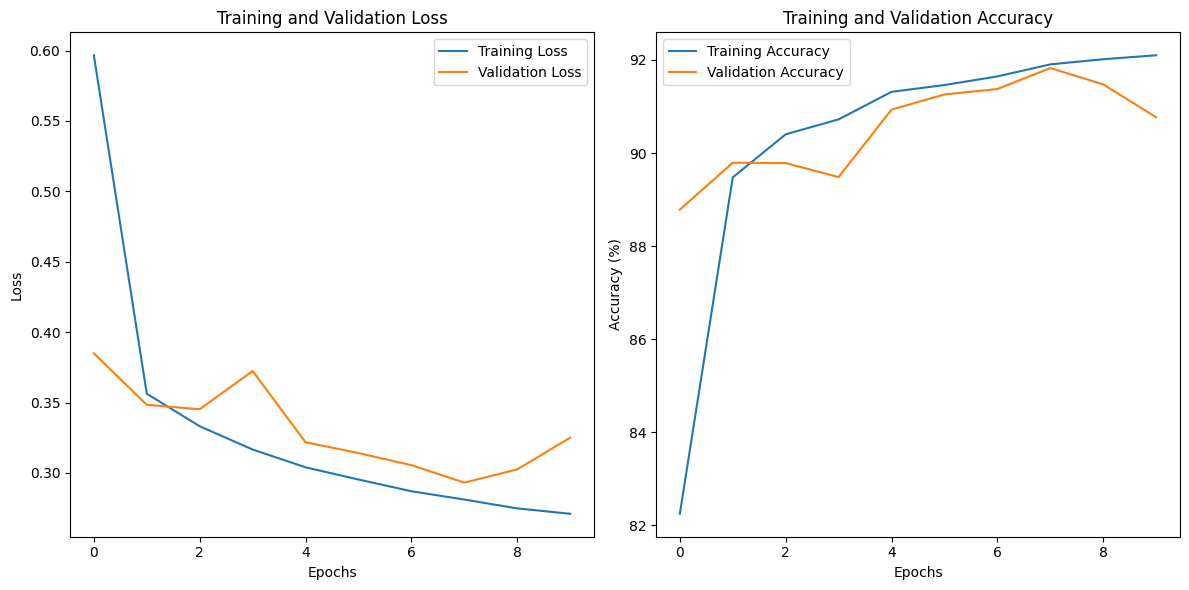

In [14]:
# 5. Plot Training and Validation Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 6. Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

## part 2
 for this part we will attempt to tune the model parameters by tweaking a single paramter(the others remain constant) and retraining the model and then comparing results we will use the following paramters:
 
 - number of hiddden layers =[1,3,5,7]
 - number of neurons per hidden layer= [10,20,30,40]
 - batch size for stochastic gradient descent= [32,64,128,256]
 - learning rate =[0.10.01,0.001,0.0001]

 in total, we train the model for a total of 16 times.

 Total iterations:
    6+6+6+6=24

 we will create a function the iterates over the said parameters but fristly we define our parameter ranges in a dictionary.

In [39]:
# Hyperparameters for tuning
default_params = {
    "hidden_layers": 1,  # Number of hidden layers
    "hidden_size": 10,   # Number of neurons per hidden layer
    "batch_size": 32,    # Batch size for SGD
    "learning_rate": 0.01  # Learning rate
}

# Define the ranges for each hyperparameter
param_ranges = {
    "hidden_layers": [1, 3, 5, 7,9,11],
    "hidden_size": [10, 20, 30, 40, 50 , 60],
    "batch_size": [32, 64, 128, 256,500, 1000 ],
    "learning_rate": [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
}

then we proceed to create a neural network class with a variable layer size

In [20]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    y_true, y_pred = [], []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move to GPU/CPU
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train * 100
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

        avg_val_loss = running_loss / len(val_loader)
        val_accuracy = correct_val / total_val * 100
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    
    # Return all six variables
    return train_losses, val_losses, train_accuracies, val_accuracies, y_true, y_pred


In [40]:
# Function to build a model with variable hidden layers
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_layers, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        layers = []
        for i in range(hidden_layers):
            if i == 0:
                layers.append(nn.Linear(input_size, hidden_size)) # for inout layer
            else:
                layers.append(nn.Linear(hidden_size, hidden_size)) ##every layer in between
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_size, num_classes))  # Final output layer
        self.network = nn.Sequential(*layers) ##link layers

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten input
        return self.network(x)

 a function that iterares over parameter values

In [41]:
# Hyperparameter tuning function
def tune_hyperparameters(default_params, param_ranges, num_epochs=10):
    results = []
    
    # Iterate over each parameter
    for param, values in param_ranges.items():
        for value in values:
            # Update the parameter value
            params = default_params.copy()
            params[param] = value
            
            # Update DataLoader if batch_size changes
            batch_size = params["batch_size"]
            train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

            # Build the model
            model = NeuralNetwork(
                input_size=28 * 28,
                hidden_layers=params["hidden_layers"],
                hidden_size=params["hidden_size"],
                num_classes=10
            ).to(device)
            
            # Define optimizer with new learning rate
            optimizer = optim.SGD(model.parameters(), lr=params["learning_rate"])
            criterion = nn.CrossEntropyLoss()
            
            # Train the model
            train_losses, val_losses, train_accuracies, val_accuracies, y_true, y_pred = train_model(
                model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs
            )
            
            # Record results
            results.append({
                "param": param,
                "value": value,
                "train_accuracy": train_accuracies[-1],
                "val_accuracy": val_accuracies[-1],
                "train_loss": train_losses[-1],
                "val_loss": val_losses[-1],
                "y_true": y_true,
                "y_pred": y_pred
            })
            
            print(f"Completed training for {param} = {value}")
    
    return results

In [42]:
results = tune_hyperparameters(default_params, param_ranges)

Epoch [1/10], Train Loss: 0.7920, Train Accuracy: 77.26%, Validation Loss: 0.4423, Validation Accuracy: 87.15%
Epoch [2/10], Train Loss: 0.4079, Train Accuracy: 88.13%, Validation Loss: 0.3692, Validation Accuracy: 89.47%
Epoch [3/10], Train Loss: 0.3610, Train Accuracy: 89.49%, Validation Loss: 0.3382, Validation Accuracy: 90.48%
Epoch [4/10], Train Loss: 0.3383, Train Accuracy: 90.17%, Validation Loss: 0.3196, Validation Accuracy: 91.15%
Epoch [5/10], Train Loss: 0.3215, Train Accuracy: 90.76%, Validation Loss: 0.3106, Validation Accuracy: 91.18%
Epoch [6/10], Train Loss: 0.3079, Train Accuracy: 91.15%, Validation Loss: 0.2990, Validation Accuracy: 91.77%
Epoch [7/10], Train Loss: 0.2962, Train Accuracy: 91.43%, Validation Loss: 0.2967, Validation Accuracy: 91.91%
Epoch [8/10], Train Loss: 0.2872, Train Accuracy: 91.69%, Validation Loss: 0.2946, Validation Accuracy: 91.76%
Epoch [9/10], Train Loss: 0.2787, Train Accuracy: 91.93%, Validation Loss: 0.2787, Validation Accuracy: 92.29%
E

In [43]:
import pandas as pd

# Convert the results list to a DataFrame
df = pd.DataFrame(results)

# Inspect the columns to ensure they match expected names
print("Columns in DataFrame:", df.columns)

# Verify sample rows to confirm data integrity
print(df.head())


Columns in DataFrame: Index(['param', 'value', 'train_accuracy', 'val_accuracy', 'train_loss',
       'val_loss', 'y_true', 'y_pred'],
      dtype='object')
           param  value  train_accuracy  val_accuracy  train_loss  val_loss  \
0  hidden_layers    1.0       92.143750     92.400000    0.272483  0.277017   
1  hidden_layers    3.0       89.995833     90.350000    0.340226  0.329295   
2  hidden_layers    5.0       87.489583     88.500000    0.437782  0.418088   
3  hidden_layers    7.0       75.837500     76.508333    0.809626  0.743543   
4  hidden_layers    9.0       11.237500     11.233333    2.301300  2.301179   

                                              y_true  \
0  [0, 5, 9, 8, 2, 7, 7, 7, 4, 4, 9, 6, 6, 6, 1, ...   
1  [0, 5, 9, 8, 2, 7, 7, 7, 4, 4, 9, 6, 6, 6, 1, ...   
2  [0, 5, 9, 8, 2, 7, 7, 7, 4, 4, 9, 6, 6, 6, 1, ...   
3  [0, 5, 9, 8, 2, 7, 7, 7, 4, 4, 9, 6, 6, 6, 1, ...   
4  [0, 5, 9, 8, 2, 7, 7, 7, 4, 4, 9, 6, 6, 6, 1, ...   

                               

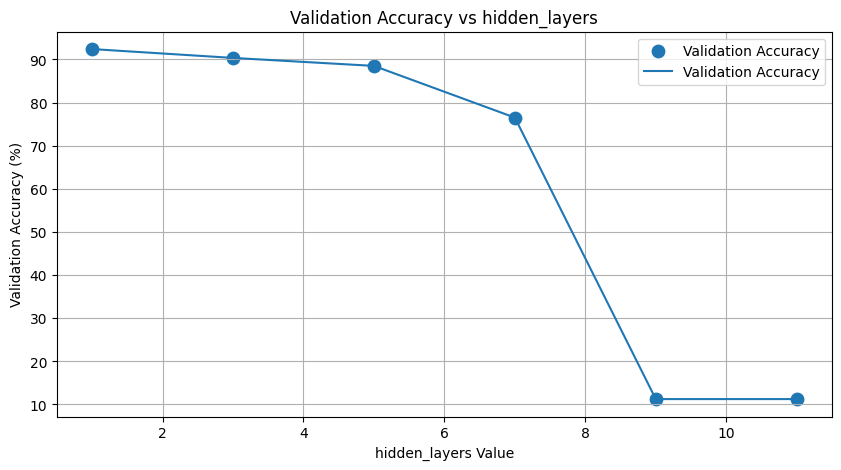

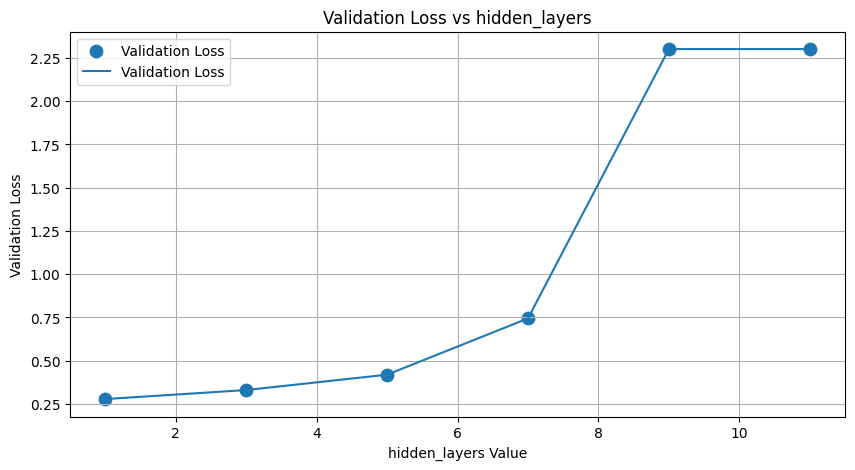

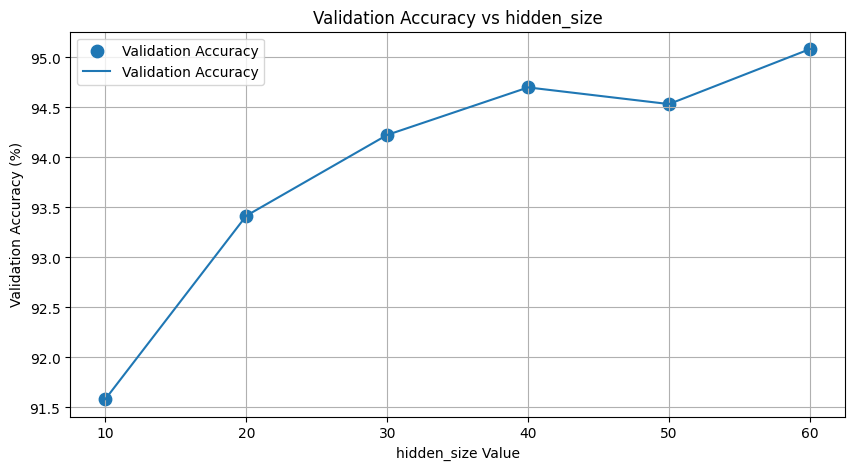

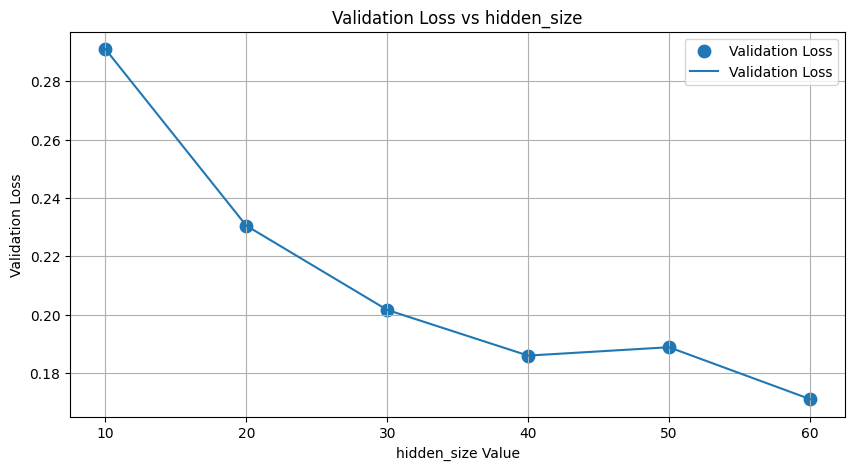

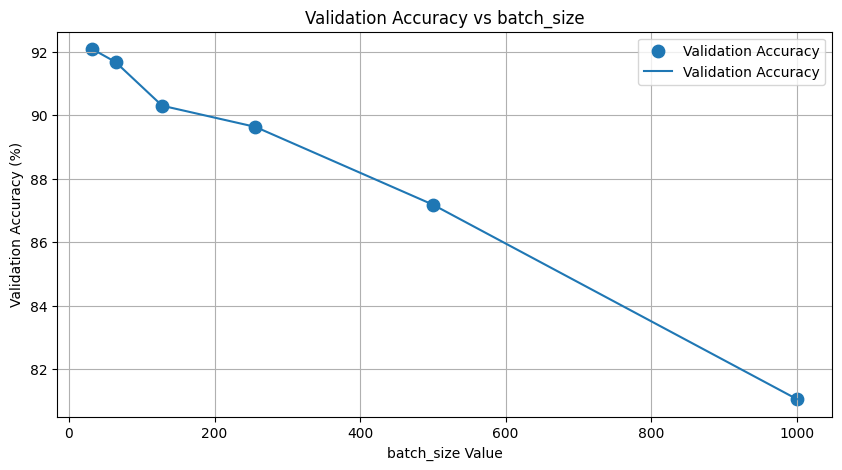

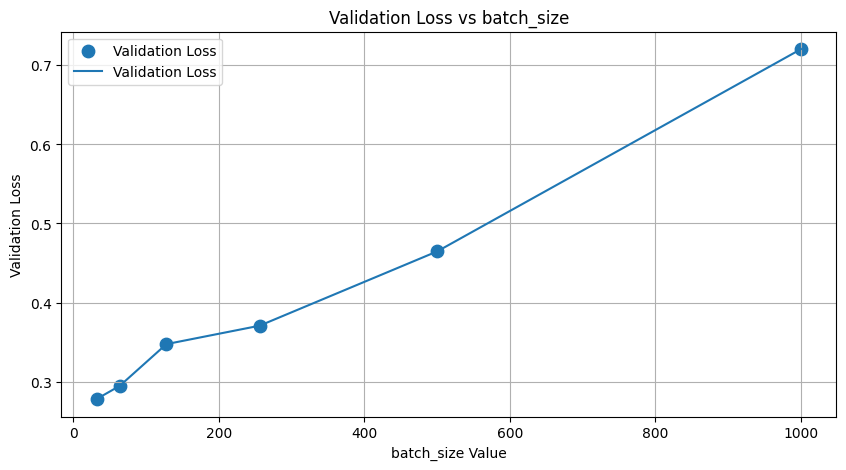

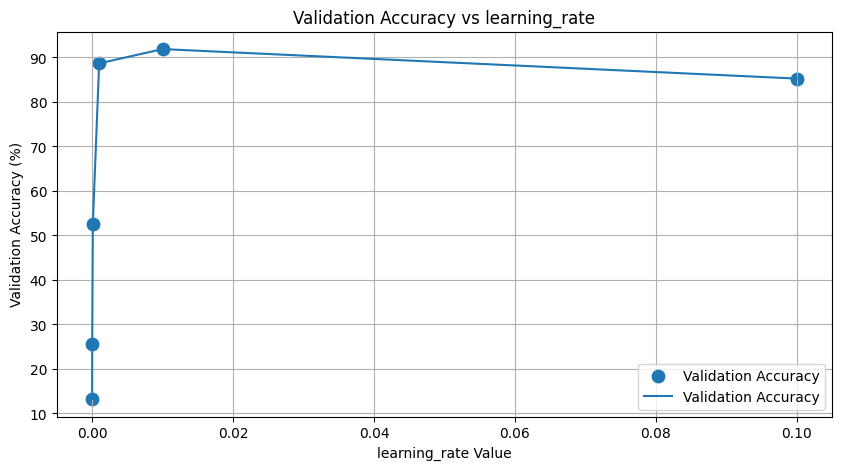

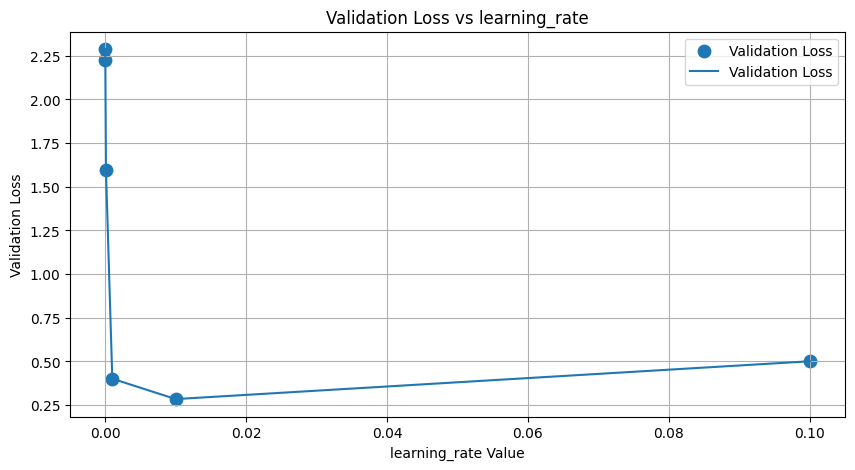

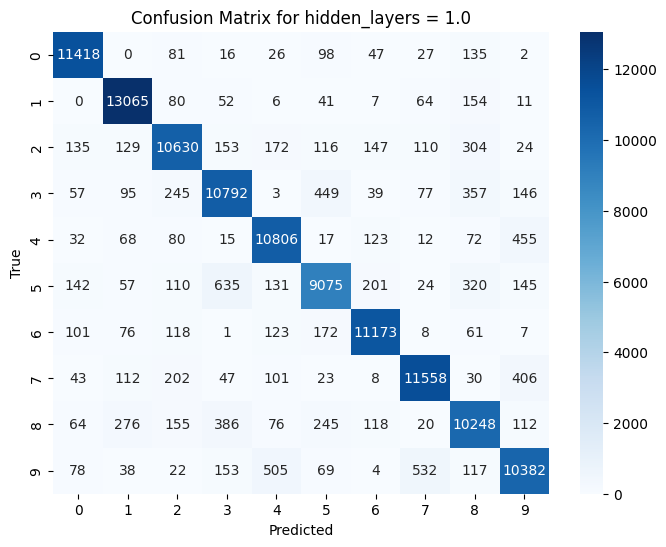

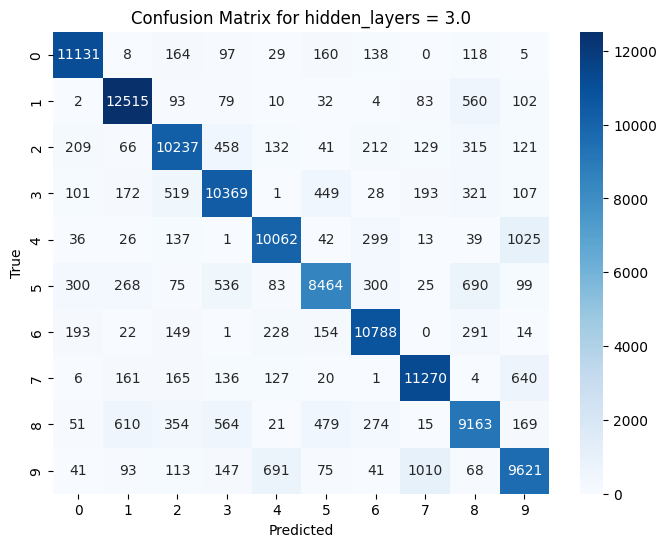

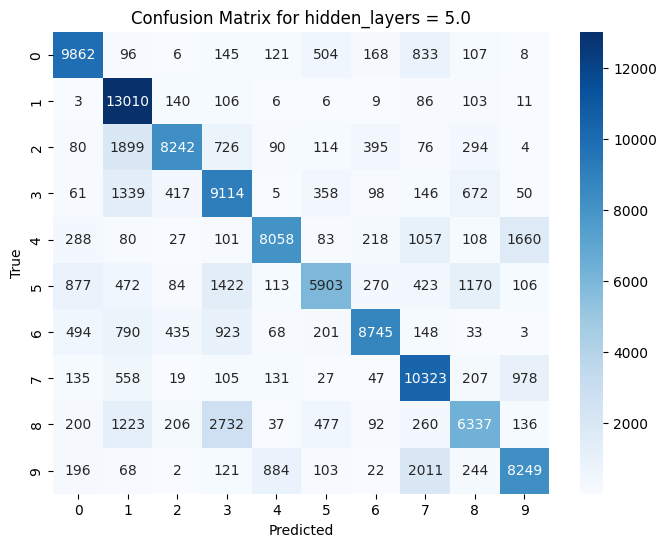

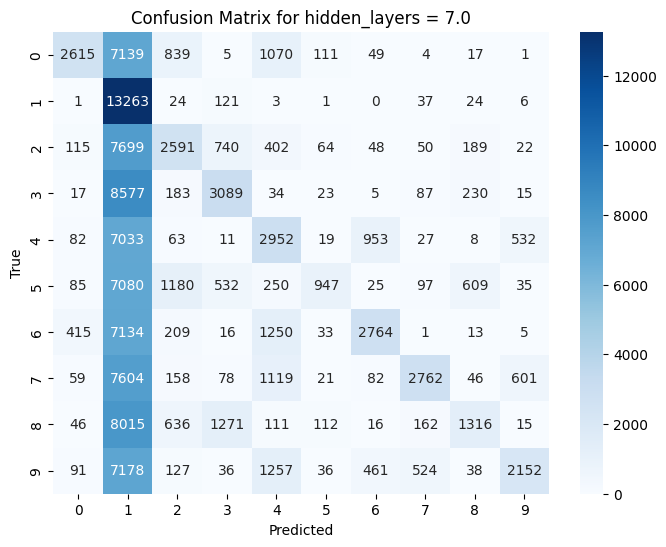

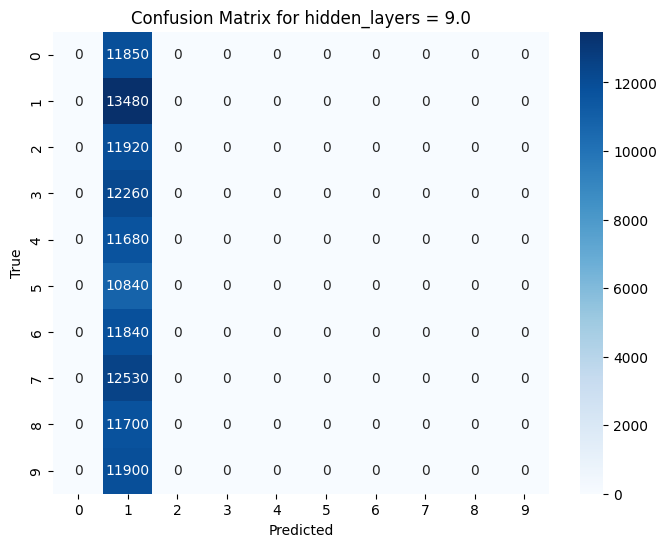

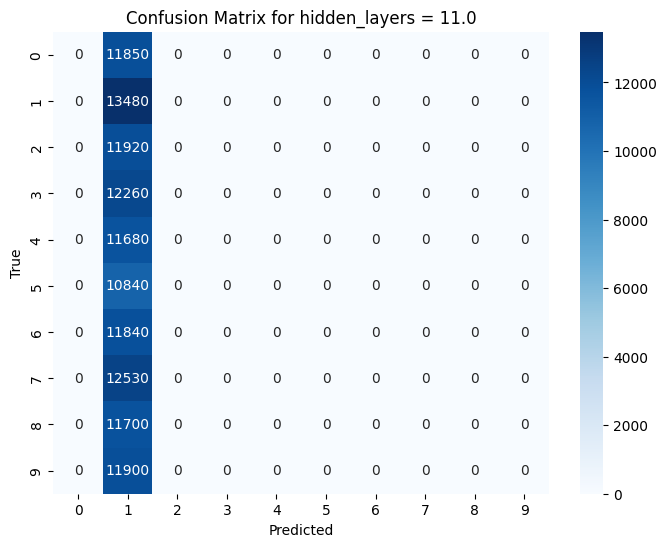

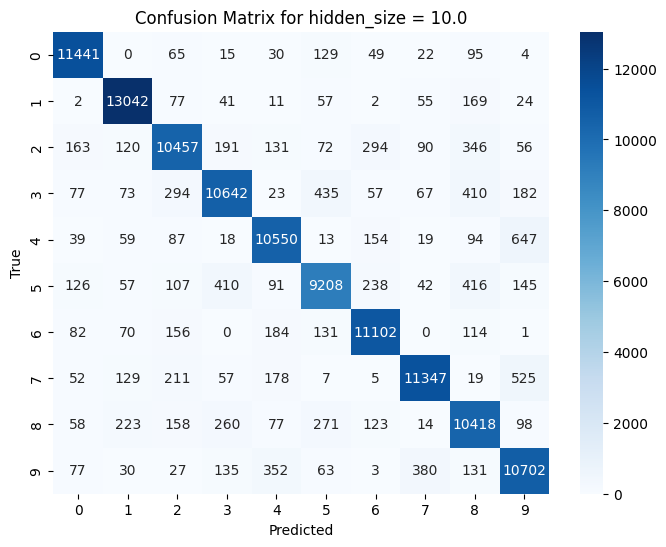

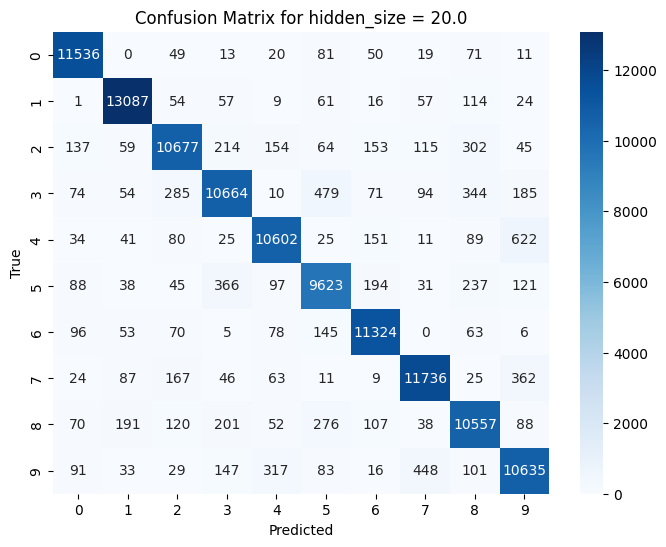

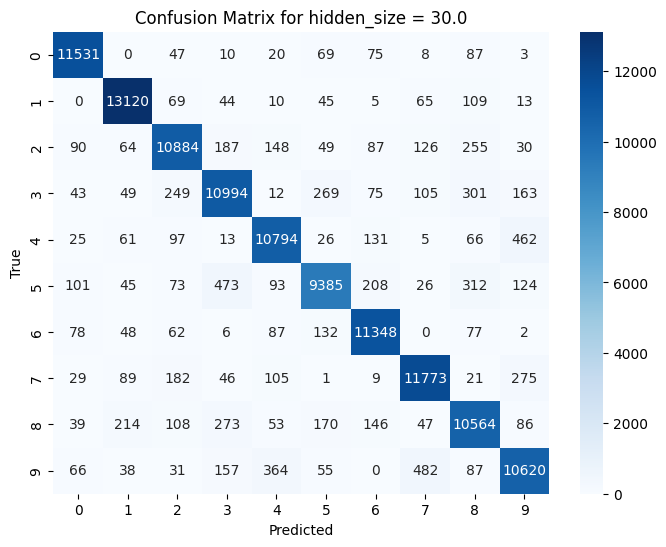

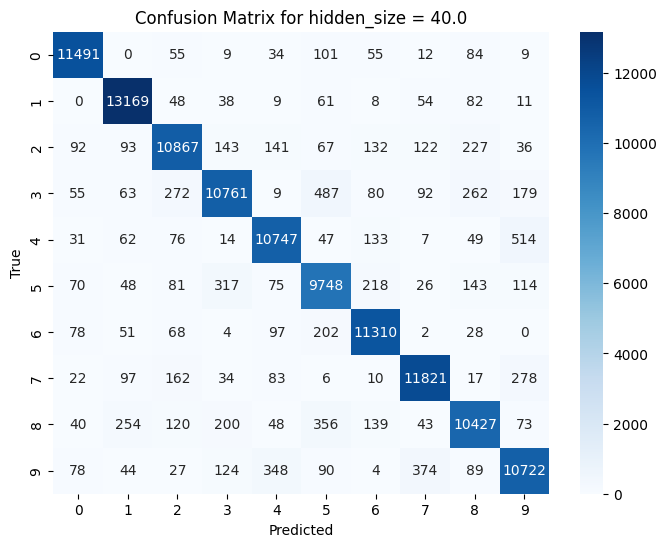

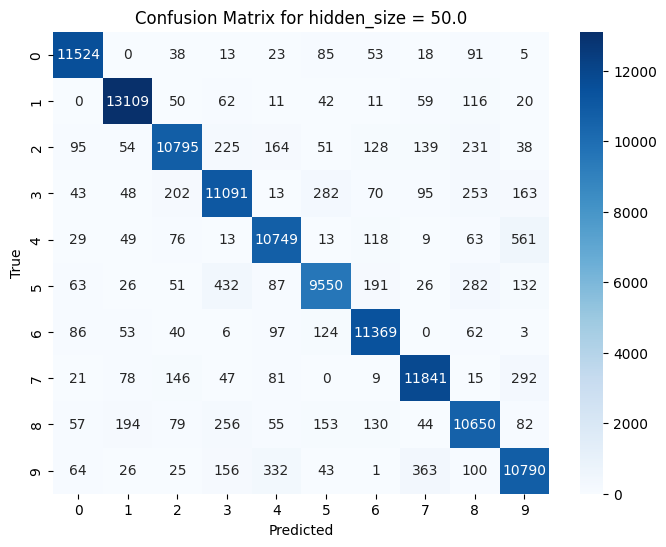

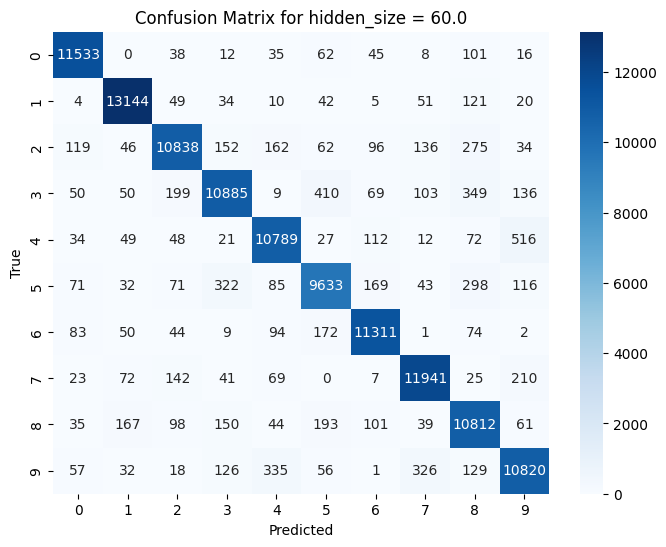

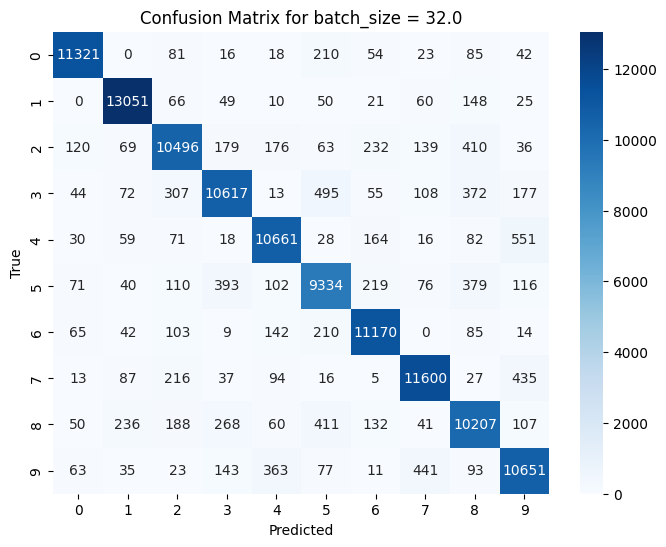

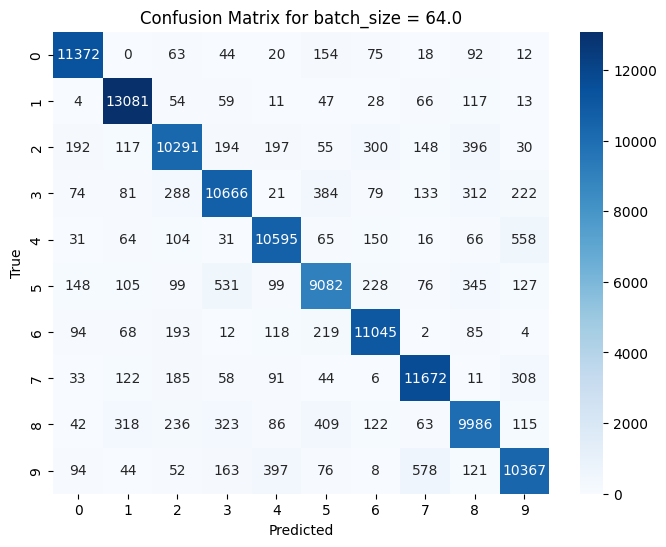

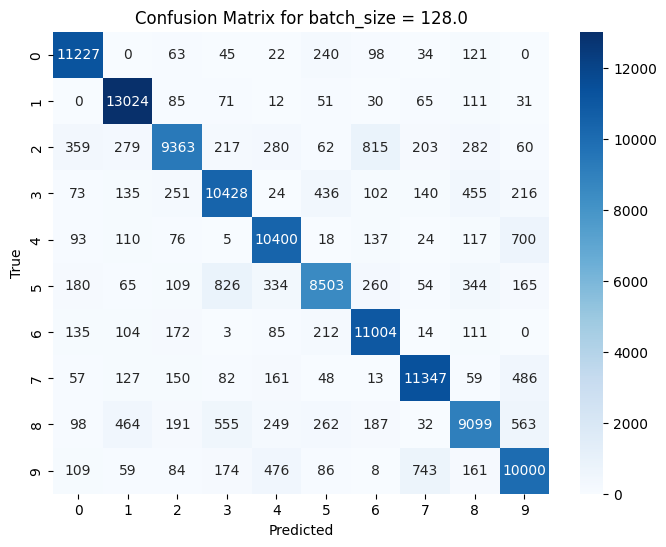

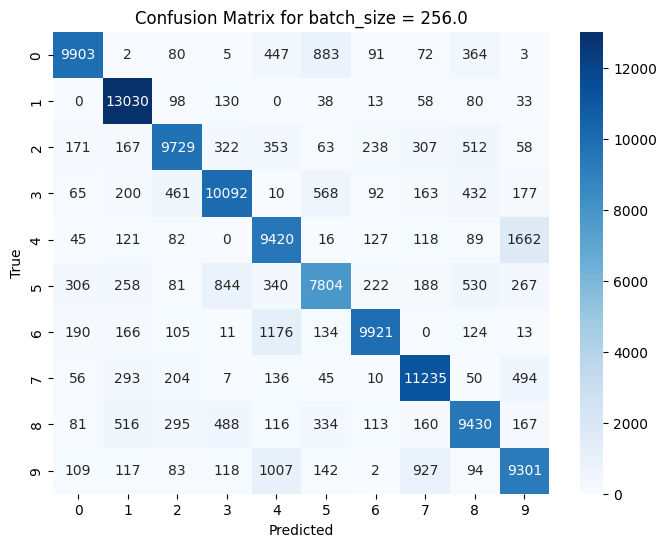

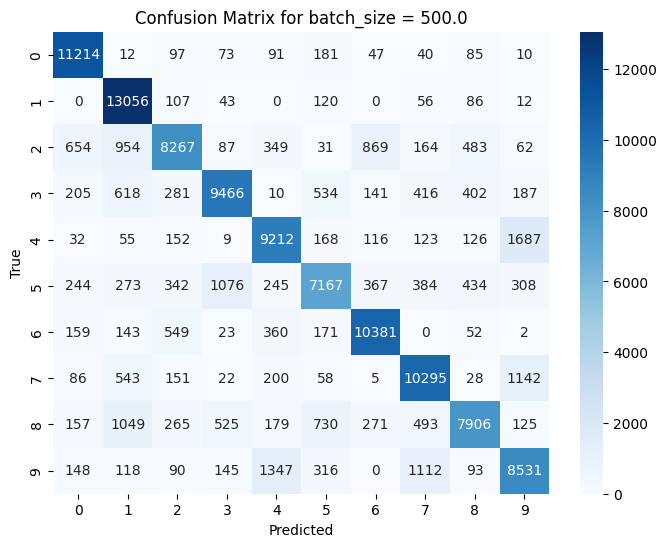

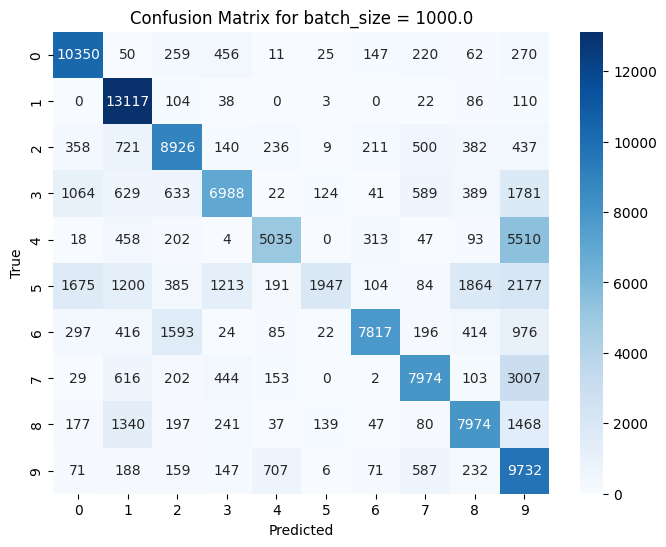

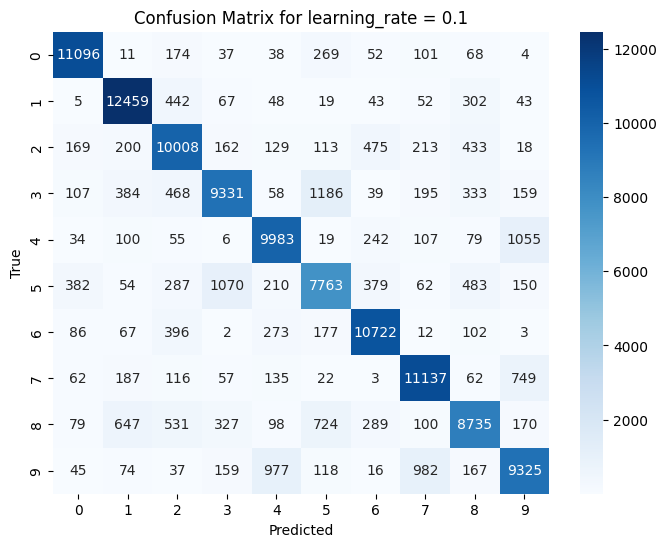

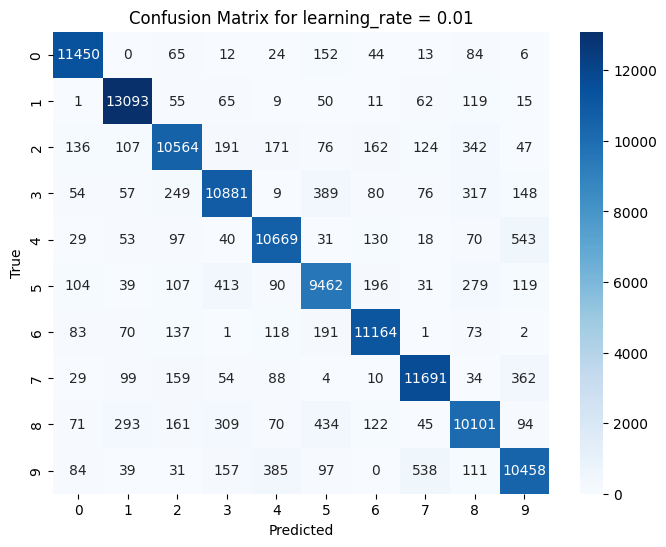

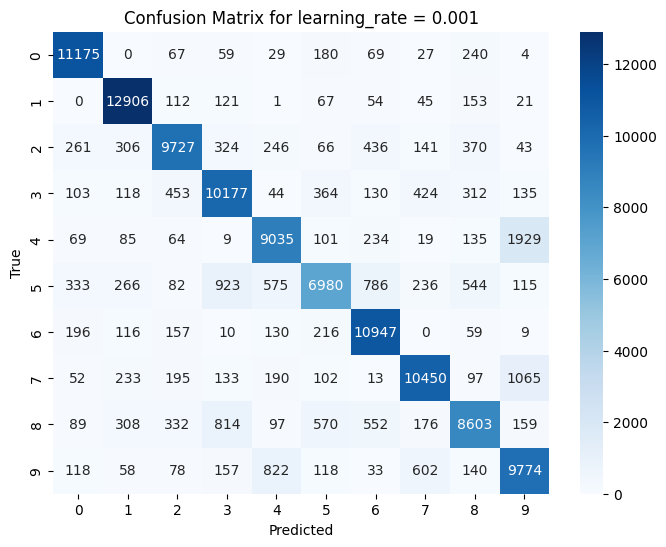

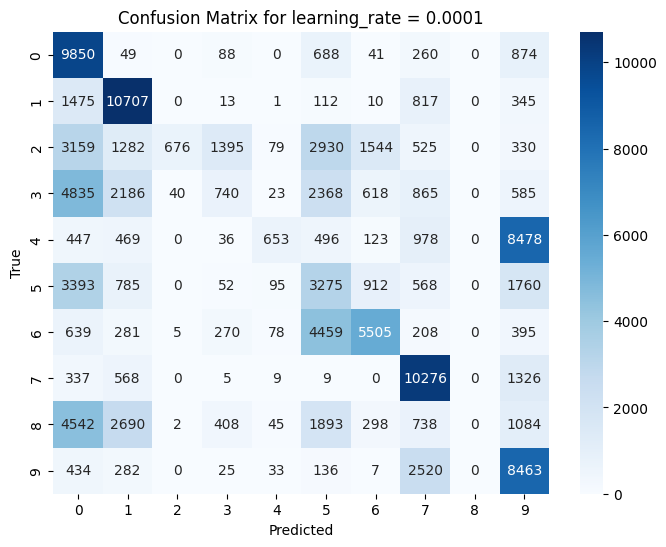

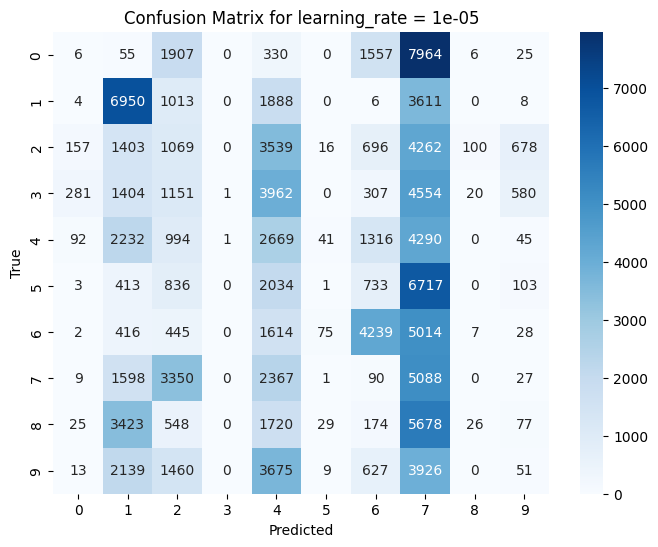

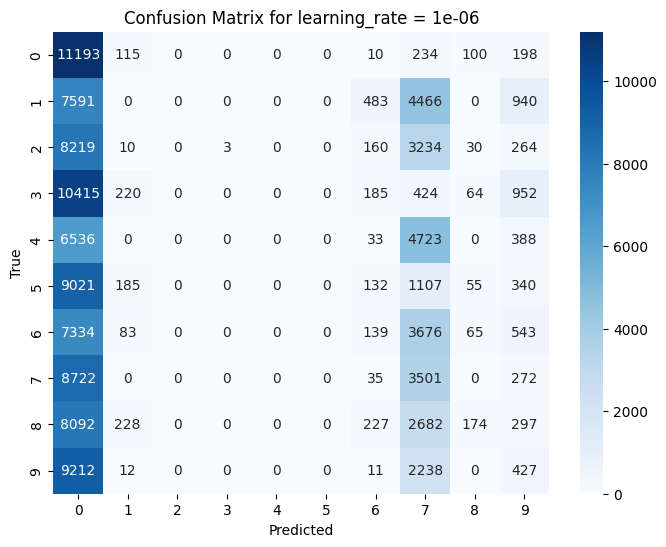

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Plot Validation Accuracy and Validation Loss for each parameter separately
unique_params = df["param"].unique()

for param in unique_params:
    # Filter the DataFrame for the current parameter
    subset = df[df["param"] == param]

    print()

    # Plot Validation Accuracy
    plt.figure(figsize=(10, 5))
    plt.scatter(subset["value"], subset["val_accuracy"], marker='o', s=80, label="Validation Accuracy")
    plt.plot(subset["value"], subset["val_accuracy"], linestyle='-', label="Validation Accuracy")
    plt.title(f"Validation Accuracy vs {param}")
    plt.xlabel(f"{param} Value")
    plt.ylabel("Validation Accuracy (%)")
    plt.grid()
    plt.legend()
    plt.show()

    # Plot Validation Loss
    plt.figure(figsize=(10, 5))
    plt.scatter(subset["value"], subset["val_loss"], marker='o', s=80, label="Validation Loss")
    plt.plot(subset["value"], subset["val_loss"], linestyle='-', label="Validation Loss")
    plt.title(f"Validation Loss vs {param}")
    plt.xlabel(f"{param} Value")
    plt.ylabel("Validation Loss")
    plt.grid()
    plt.legend()
    plt.show()


# Plot confusion matrix for each trained model
def plot_confusion_matrix(y_true, y_pred, param, value):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
    plt.title(f'Confusion Matrix for {param} = {value}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Generate confusion matrices for each parameter and value
for idx, row in df.iterrows():
    plot_confusion_matrix(row["y_true"], row["y_pred"], row["param"], row["value"])
